# Mix EMA & Couple candlesticks & Momentum - Strategy - Backtesting 

In [1]:
# Giu nguyen Rule Long-Short cu, optimize QTY

### Import Library

In [2]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)
from backtesting import set_bokeh_output
set_bokeh_output(notebook=False)

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [3]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [4]:
data = dataset.copy()

In [5]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [6]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [7]:
def get_ema_signal(r):
    signal = ''
    if r['ema_fast_s1'] < r['ema_low_s1'] and r['ema_fast'] > r['ema_low']:
        signal = 'long'
    elif r['ema_fast_s1'] > r['ema_low_s1'] and r['ema_fast'] < r['ema_low']:
        signal = 'short'
    return signal

In [8]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond


def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] == r['Low'] and r['Low'] < r['low_s1']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] == r['High'] and r['High'] > r['high_s1']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond
    

def get_couple_candleticks_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [9]:
def cal_signal(row):
    signal = ''
    if not row['first_close']:
        return signal
    if row['Close'] - row['prev_low'] > 21 or row['prev_high'] - row['Close'] > 21:
        return signal
    if row['mom_y'] > 0.26 and row['body_rate'] > .65:
        signal = 'long'
    elif row['mom_y'] < -.18 and row['body_rate'] < -.39:
        signal = 'short'
    return signal


def cal_first_close(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 915]
    if not tick.empty:
        return tick[0]


def cal_high_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1345]
    return tick.max()


def cal_low_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1355]
    return tick.min()


def cal_last(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1445]
    if not tick.empty:
        return tick[0]

def cal_price(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1355]
    if not tick.empty:
        return tick[0]
        
def get_day_data(htd):
    data_tmp = htd.copy()
    data_tmp['first_close'] = data_tmp.Close
    data_tmp['_2pm_price'] = data_tmp.Close
    data_tmp['_last'] = data_tmp.Close
    data_tmp['prev_high'] = data_tmp.High
    data_tmp['prev_low'] = data_tmp.Low
    day_data = data_tmp.resample("D").agg({
        'first_close': cal_first_close,
        'prev_high': cal_high_before,
        'prev_low': cal_low_before,
        '_2pm_price': cal_price,
        '_last': cal_last
    }).rename(columns={'_last': 'day_Close'})
    day_data.dropna(subset=['day_Close'], inplace=True)
    day_data['prev_day_Close'] = day_data['day_Close'].shift(1)
    day_data.drop(columns=['day_Close'], inplace=True)
    return day_data[['prev_day_Close', 'first_close', 'prev_high', 'prev_low']]

def add_momentum_signal(data):
    clone_data = data.copy()
    day_data = get_day_data(clone_data)
    clone_data = clone_data.assign(time_d=pd.PeriodIndex(clone_data.index, freq='1D').to_timestamp())
    df_merged = pd.merge(clone_data, day_data, left_on="time_d", right_index=True, how="left")
    # df_merged = clone_data.merge(day_data, how='left', left_index=True, right_index=True)
    df_merged['mom_y'] = df_merged.apply(lambda r: 100 * (r['Close'] - r['prev_day_Close']) / r['prev_day_Close'] if r['first_close'] else 0, axis=1)
    df_merged['body_rate'] = df_merged.apply(lambda r: (r['Close'] - r['first_close']) / (r['prev_high'] - r['prev_low']) if r['first_close'] else 0, axis=1)
    df_merged['momentum_signal'] = df_merged.apply(lambda r: cal_signal(r), axis=1)
    df_merged.loc[100 * df_merged.index.hour + df_merged.index.minute != 1355, 'momentum_signal'] = ''
    return df_merged
    

In [10]:
def prepare_data(data):
    data["current"] = data.index + pd.DateOffset(minutes=5)
    # EMA signal
    data['max_in_range'] = data['High'].rolling(10).max()
    data['min_in_range'] = data['Low'].rolling(10).min()
    data["ema_superfast"] = ta.ema(data["Close"], length=10)
    data["ema_fast"] = ta.ema(data["Close"], length=20)
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['ema_fast_s1'] = data['ema_fast'].shift(1)
    data['ema_low_s1'] = data['ema_low'].shift(1)
    data['ema_signal'] = data.apply(lambda r: get_ema_signal(r), axis=1)
    # Couple candlesticks signal
    data['low_s1'] = data['Low'].shift(1)
    data['high_s1'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['couple_cs_signal'] = data.apply(lambda r: get_couple_candleticks_signal(r), axis=1)
    # Momentum signal
    data = add_momentum_signal(data)
    # Optimnize
    data['RSI_14'] = ta.rsi(data["Close"], length=14)
    data['RSI_20'] = ta.rsi(data["Close"], length=20)
    data["ATR_14"] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
    data["ATR_20"] = ta.atr(data['High'], data['Low'], data['Close'], length=20)
    data['body'] = data.apply(lambda r: abs(r['Close'] - r['Open']), axis=1)
    data['ibs'] = data.apply(lambda x: (-10 if (x["High"] == x["Low"]) else 10 * (x["Close"] - x["Low"]) / (x["High"] - x["Low"])), axis=1)
    data["vol_20_mean"] = data["Volume"].rolling(20).mean()
    data["diff_vol_percent"] = (data["Volume"] - data["Volume"].shift(1)) * 100 / data["Volume"].shift(1)
    data["vol_20_mean_s1"] = data["vol_20_mean"].shift(1)
    data["vol_20_mean_s2"] = data["vol_20_mean"].shift(3)
    data["vol_20_mean_s3"] = data["vol_20_mean"].shift(5)
    data["vol_20_mean_s4"] = data["vol_20_mean"].shift(7)
    data["vol_20_mean_s5"] = data["vol_20_mean"].shift(9)
    macd = ta.macd(data['Close'], 26, 12, 9)
    data = data.assign(MACDh=macd['MACDh_12_26_9'])
    return data

In [11]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013


In [12]:
prepared_data = prepare_data(data)
prepared_data.dropna(subset=['Close', 'ATR_20', 'RSI_20'],inplace=True)

In [13]:
prepared_data

,Open,High,Low,Close,Volume,current,max_in_range,min_in_range,ema_superfast,ema_fast,...,body,ibs,vol_20_mean,diff_vol_percent,vol_20_mean_s1,vol_20_mean_s2,vol_20_mean_s3,vol_20_mean_s4,vol_20_mean_s5,MACDh
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-02 10:40:00,899.2,899.4,898.8,899.4,1652,2020-11-02 10:45:00,901.5,898.6,899.678966,899.422619,...,0.2,10.000000,1797.30,49.367089,1810.20,NaN,NaN,NaN,NaN,NaN
2020-11-02 10:45:00,899.4,900.2,896.7,897.9,3197,2020-11-02 10:50:00,901.5,896.7,899.355517,899.277608,...,1.5,3.428571,1873.65,93.523002,1797.30,NaN,NaN,NaN,NaN,NaN
2020-11-02 10:50:00,897.8,898.9,896.8,898.3,2997,2020-11-02 10:55:00,901.5,896.7,899.163605,899.184502,...,0.5,7.142857,1957.05,-6.255865,1873.65,1810.20,NaN,NaN,NaN,NaN
2020-11-02 10:55:00,898.0,898.3,897.2,897.3,1668,2020-11-02 11:00:00,901.5,896.7,898.824768,899.005026,...,0.7,0.909091,1954.35,-44.344344,1957.05,1797.30,NaN,NaN,NaN,NaN
2020-11-02 11:00:00,897.3,897.4,895.4,897.0,3418,2020-11-02 11:05:00,901.5,895.4,898.492992,898.814071,...,0.3,8.000000,1978.30,104.916067,1954.35,1873.65,1810.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.4,1342.4,1344.2,5075,2025-02-07 14:20:00,1347.4,1341.2,1343.886991,1342.719356,...,0.9,9.000000,3960.85,-22.766702,3846.60,3458.35,3460.20,3134.40,2379.6,0.108468
2025-02-07 14:20:00,1344.2,1344.7,1343.6,1344.0,4865,2025-02-07 14:25:00,1347.4,1342.0,1343.907538,1342.841322,...,0.2,3.636364,4108.35,-4.137931,3960.85,3608.35,3508.05,3274.00,2544.2,0.023621
2025-02-07 14:25:00,1344.1,1344.2,1342.8,1343.3,5013,2025-02-07 14:30:00,1347.4,1342.4,1343.797076,1342.885006,...,0.8,3.571429,4290.60,3.042138,4108.35,3846.60,3458.35,3460.20,3134.4,-0.087771


In [14]:
backtest_data = prepared_data[['Open', 'Close', 'High', 'Low', 'min_in_range', 'max_in_range', 'min_5', 'max_5', 'ema_signal', 'momentum_signal', 'couple_cs_signal']]
backtest_data[(backtest_data.ema_signal != '') | (backtest_data.momentum_signal != '') | (backtest_data.couple_cs_signal != '')]

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal
Date,,,,,,,,,,,
2020-11-02 14:25:00,904.9,907.0,907.0,904.5,896.6,907.0,896.6,907.0,,,long
2020-11-03 09:20:00,908.5,908.1,908.8,908.1,897.4,909.4,908.1,909.4,,,short
2020-11-04 09:35:00,907.8,907.3,908.0,907.3,907.3,909.9,907.3,908.8,,,short
2020-11-04 10:05:00,908.2,909.0,909.0,908.1,906.7,909.0,906.8,909.0,,,long
2020-11-04 10:15:00,910.2,911.5,911.5,909.8,906.7,911.5,907.6,911.5,,,long
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-05 13:15:00,1332.2,1331.6,1332.5,1331.6,1331.0,1333.4,1331.5,1332.6,,,short
2025-02-05 13:25:00,1331.7,1330.9,1332.1,1330.9,1330.9,1332.6,1330.9,1332.6,,,short
2025-02-05 13:50:00,1331.9,1333.4,1333.4,1331.5,1329.6,1333.4,1329.6,1333.4,,,long


In [15]:
backtest_data[backtest_data.momentum_signal != '']

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal
Date,,,,,,,,,,,
2020-11-04 13:55:00,912.8,916.3,917.2,912.5,912.1,917.2,912.4,917.2,,long,
2020-11-06 13:55:00,908.3,907.3,908.4,906.7,903.3,908.6,903.5,908.6,,short,
2020-11-11 13:55:00,914.3,915.6,915.7,914.0,914.0,921.2,914.0,921.0,,short,
2020-11-13 13:55:00,931.6,932.9,933.4,931.2,929.2,933.4,929.2,933.4,,long,
2020-11-16 13:55:00,928.2,933.5,933.8,928.2,925.5,936.3,925.5,934.0,,short,
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10 13:55:00,1307.2,1309.3,1309.3,1306.2,1305.2,1310.4,1305.2,1309.3,,short,
2025-01-17 13:55:00,1312.9,1315.4,1316.7,1312.8,1309.6,1316.7,1310.8,1316.7,,long,
2025-01-21 13:55:00,1317.6,1319.4,1319.9,1317.6,1316.6,1324.4,1316.6,1320.3,,short,


In [16]:
backtest_data

,Open,Close,High,Low,min_in_range,max_in_range,min_5,max_5,ema_signal,momentum_signal,couple_cs_signal
Date,,,,,,,,,,,
2020-11-02 10:40:00,899.2,899.4,899.4,898.8,898.6,901.5,898.8,901.2,,,
2020-11-02 10:45:00,899.4,897.9,900.2,896.7,896.7,901.5,896.7,900.4,,,
2020-11-02 10:50:00,897.8,898.3,898.9,896.8,896.7,901.5,896.7,900.4,,,
2020-11-02 10:55:00,898.0,897.3,898.3,897.2,896.7,901.5,896.7,900.4,,,
2020-11-02 11:00:00,897.3,897.0,897.4,895.4,895.4,901.5,895.4,900.2,,,
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-07 14:15:00,1343.3,1344.2,1344.4,1342.4,1341.2,1347.4,1342.4,1346.5,,,
2025-02-07 14:20:00,1344.2,1344.0,1344.7,1343.6,1342.0,1347.4,1342.4,1346.5,,,
2025-02-07 14:25:00,1344.1,1343.3,1344.2,1342.8,1342.4,1347.4,1342.4,1346.5,,,


In [17]:
class MainStrategy(Strategy):
    max_sl = 3.5
    #
    ema_trailing_sl = 5.5
    ema_tp_step = 27
    #
    momentum_trailing_sl = 4.5
    momentum_tp_step = 27
    #
    cs_trailing_sl = 7.5
    cs_tp_step = 27
    #
    def init(self):
        self._broker._cash = 1500
        self.strategy = ''
        super().init()

    def next(self):
        super().next()
        close_price = self.data.Close[-1]
        # Strategy trailing stoploss
        if self.strategy == 'ema':
            if self.position.is_long:
                max_in_range = self.data.max_in_range[-1]
                if close_price < max_in_range - self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_in_range = self.data.min_in_range[-1]
                if close_price > min_in_range + self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
        elif self.strategy == 'couple_cs':
            if self.position.is_long:
                max_5 = self.data.max_5[-1]
                if close_price < max_5 - self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_5 = self.data.min_5[-1]
                if close_price > min_5 + self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()

        # Close deal at 14:00
        if self.strategy == 'couple_cs' or self.strategy == 'momentum':
            _time = self.data.index
            current_time = _time[-1]
            if current_time.hour == 14 and current_time.minute >= 25:
                if self.position.is_long or self.position.is_short:
                    self.strategy = ''
                    self.position.close()
                return
            
        # Main Strategy
        ema_signal = self.data.ema_signal[-1]
        momentum_signal = self.data.momentum_signal[-1]
        couple_cs_signal = self.data.couple_cs_signal[-1]
        if self.position:
            # return
            if self.strategy != 'ema':
                if self.position.is_long and ema_signal == 'long':
                    self.strategy = 'ema'
                elif self.position.is_short and ema_signal == 'short':
                    self.strategy = 'ema'
        else:
            if ema_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.ema_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                self.strategy = 'ema'
            elif ema_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.ema_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'ema'
            elif momentum_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.momentum_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                # print(f'sl: {sl}, tp: {tp}')
                self.strategy = 'momentum'
            elif momentum_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.momentum_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'momentum'
                # print(f'sl: {sl}, tp: {tp}')
            elif couple_cs_signal == 'long':
                # print('couple_cs_signal')
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.cs_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                self.strategy = 'couple_cs'
            elif couple_cs_signal == 'short':
                # print('couple_cs_signal2')
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.cs_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'couple_cs'

In [18]:
bt = Backtest(backtest_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [19]:
stats

Start                     2020-11-02 10:40:00
End                       2025-02-07 14:45:00
Duration                   1558 days 04:05:00
Exposure Time [%]                   48.268674
Equity Final [$]                    2973.5509
Equity Peak [$]                    2983.25437
Return [%]                          98.236727
Buy & Hold Return [%]               49.355126
Return (Ann.) [%]                   17.649399
Volatility (Ann.) [%]                7.792127
Sharpe Ratio                          2.26503
Sortino Ratio                        5.342631
Calmar Ratio                         4.665192
Max. Drawdown [%]                   -3.783209
Avg. Drawdown [%]                   -0.306156
Max. Drawdown Duration      114 days 00:30:00
Avg. Drawdown Duration        3 days 01:32:00
# Trades                                 1623
Win Rate [%]                         37.58472
Best Trade [%]                       3.309918
Worst Trade [%]                     -0.910953
Avg. Trade [%]                    

In [20]:
stats['_trades'].tail(20)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
1603,-1,53277,53287,1323.90271,1319.7,4.20271,0.003174,2025-01-07 13:40:00,2025-01-07 14:30:00,None,0 days 00:50:00
1604,1,53294,53302,1318.19534,1314.2,-3.99534,-0.003031,2025-01-08 09:25:00,2025-01-08 10:05:00,None,0 days 00:40:00
1605,-1,53304,53309,1311.90631,1315.7,-3.79369,-0.002892,2025-01-08 10:15:00,2025-01-08 10:40:00,None,0 days 00:25:00
1606,-1,53353,53389,1321.20352,1311.9,9.30352,0.007042,2025-01-09 10:05:00,2025-01-09 14:30:00,None,0 days 04:25:00
1607,-1,53418,53440,1311.00658,1295.6,15.40658,0.011752,2025-01-10 11:15:00,2025-01-10 14:30:00,None,0 days 03:15:00
1608,1,53460,53465,1292.38760,1288.5,-3.88760,-0.003008,2025-01-13 10:30:00,2025-01-13 10:55:00,None,0 days 00:25:00
1609,1,53484,53491,1295.18844,1298.0,2.81156,0.002171,2025-01-13 13:55:00,2025-01-13 14:30:00,None,0 days 00:35:00
1610,-1,53496,53542,1295.01138,1290.2,4.81138,0.003715,2025-01-14 09:15:00,2025-01-14 14:30:00,None,0 days 05:15:00
1611,1,53601,53616,1308.19234,1304.2,-3.99234,-0.003052,2025-01-16 09:30:00,2025-01-16 10:45:00,None,0 days 01:15:00
1612,-1,53629,53646,1300.20982,1308.9,-8.69018,-0.006684,2025-01-16 13:15:00,2025-01-17 09:00:00,None,0 days 19:45:00


In [21]:
stats['_trades']['PnL'].min()

-11.658729999999878

In [22]:
trades = stats['_trades']

In [23]:
trades[trades.EntryTime > '2024-01-01 00:00:00']['PnL'].sum()

265.93195000001424

In [24]:
trades[(trades.EntryTime > '2023-01-01 00:00:00') & (trades.EntryTime < '2024-01-01 00:00:00')]['PnL'].sum()

392.32576000000927

In [25]:
trades[(trades.EntryTime > '2022-01-01 00:00:00') & (trades.EntryTime < '2023-01-01 00:00:00')]['PnL'].sum()

516.079070000016

In [26]:
trades[trades.PnL < -3.1]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
2,-1,90,97,907.02781,910.8,-3.77219,-0.004159,2020-11-04 09:40:00,2020-11-04 10:15:00,None,0 days 00:35:00
11,-1,620,636,935.71920,939.6,-3.88080,-0.004147,2020-11-18 11:30:00,2020-11-18 14:15:00,None,0 days 02:45:00
13,-1,700,729,946.91584,950.6,-3.68416,-0.003891,2020-11-20 09:40:00,2020-11-20 13:30:00,None,0 days 03:50:00
15,1,813,825,962.28860,958.2,-4.08860,-0.004249,2020-11-24 10:35:00,2020-11-24 13:00:00,None,0 days 02:25:00
16,-1,836,837,953.31392,957.5,-4.18608,-0.004391,2020-11-24 13:55:00,2020-11-24 14:00:00,None,0 days 00:05:00
...,...,...,...,...,...,...,...,...,...,...,...
1608,1,53460,53465,1292.38760,1288.5,-3.88760,-0.003008,2025-01-13 10:30:00,2025-01-13 10:55:00,None,0 days 00:25:00
1611,1,53601,53616,1308.19234,1304.2,-3.99234,-0.003052,2025-01-16 09:30:00,2025-01-16 10:45:00,None,0 days 01:15:00
1612,-1,53629,53646,1300.20982,1308.9,-8.69018,-0.006684,2025-01-16 13:15:00,2025-01-17 09:00:00,None,0 days 19:45:00
1619,-1,54011,54015,1321.50343,1325.3,-3.79657,-0.002873,2025-02-04 09:40:00,2025-02-04 10:00:00,None,0 days 00:20:00


In [27]:
trades[trades.PnL < -3.1]['PnL'].sum()

-3247.808599999968

In [28]:
len(trades[trades.PnL < -3.1]) * -3.1

-2545.1

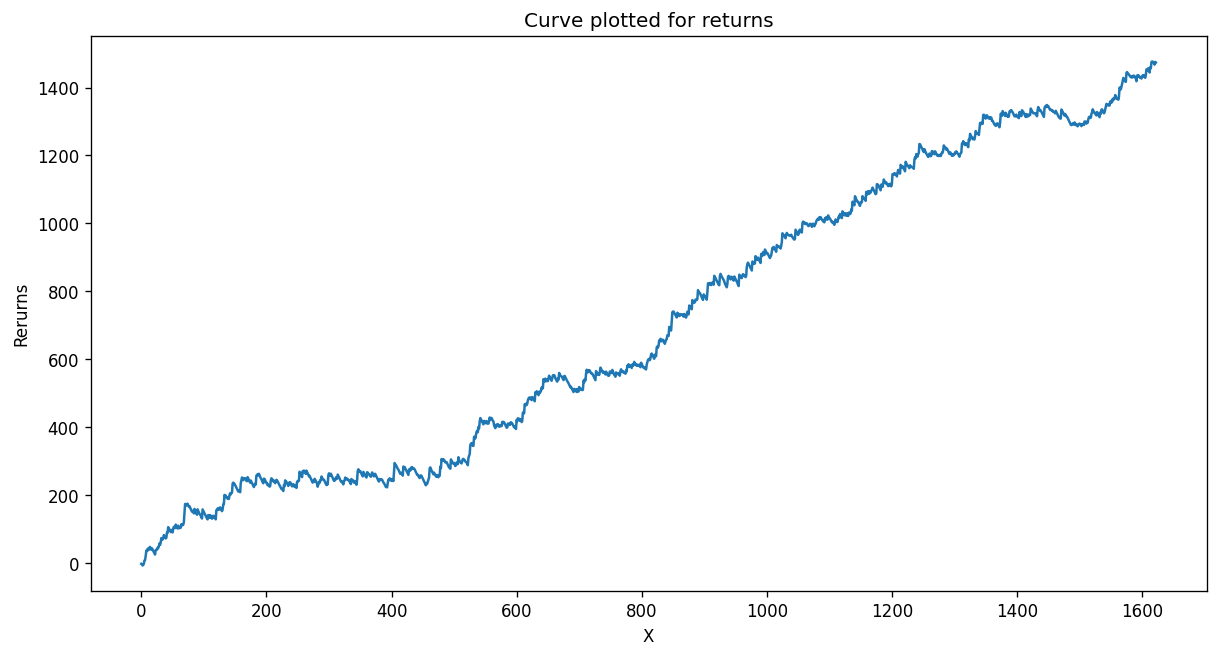

In [29]:
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [30]:
trades[trades.EntryTime > '2024-01-01 00:00:00']['PnL'].sum()

265.93195000001424

## Optimize profit

In [31]:
join_trades = pd.merge(trades, prepared_data, left_on="EntryTime", right_on='current', how="left")
join_trades.tail(30)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,body,ibs,vol_20_mean,diff_vol_percent,vol_20_mean_s1,vol_20_mean_s2,vol_20_mean_s3,vol_20_mean_s4,vol_20_mean_s5,MACDh
1593,1,52880,52886,1349.50473,1351.1,1.59527,0.001182,2024-12-25 14:00:00,2024-12-25 14:30:00,None,...,1.9,0.000000,4366.00,52.878020,4537.30,4451.95,5064.20,5209.60,5396.70,-0.837067
1594,-1,52912,52937,1348.19542,1348.6,-0.40458,-0.000300,2024-12-26 11:00:00,2024-12-26 14:30:00,None,...,1.3,0.000000,2214.65,-2.094619,2202.65,2002.25,2431.75,2567.80,3084.55,0.013839
1595,-1,52966,52984,1351.99428,1356.0,-4.00572,-0.002963,2024-12-27 11:15:00,2024-12-27 14:10:00,None,...,0.2,0.000000,1762.05,13.678516,1742.00,1830.45,1872.80,2094.35,1970.95,-0.195013
1596,-1,53000,53039,1344.89641,1344.7,0.19641,0.000146,2024-12-30 09:50:00,2024-12-30 14:30:00,None,...,0.3,0.000000,3871.35,55.887850,4022.50,4229.70,4138.65,3897.00,3734.25,-0.427196
1597,1,53056,53067,1351.70539,1347.6,-4.10539,-0.003037,2024-12-31 10:15:00,2024-12-31 11:10:00,None,...,1.9,10.000000,3032.55,243.172952,2861.45,2906.90,2951.50,3022.55,3074.95,0.141389
1598,-1,53097,53136,1348.19542,1345.8,2.39542,0.001777,2025-01-02 10:00:00,2025-01-03 09:00:00,None,...,1.3,0.000000,3457.00,-25.488632,3411.85,3272.55,2498.65,2276.00,2177.45,0.468030
1599,1,53156,53160,1340.30197,1336.3,-4.00197,-0.002986,2025-01-03 10:40:00,2025-01-03 11:00:00,None,...,1.1,10.000000,2811.55,19.580878,3027.05,2879.75,3002.80,3379.10,3627.05,-0.096159
1600,-1,53179,53185,1330.10085,1326.4,3.70085,0.002782,2025-01-03 14:00:00,2025-01-03 14:30:00,None,...,1.9,7.500000,3710.55,32.431551,3595.35,3508.95,2948.30,3122.45,3130.55,-0.007797
1601,-1,53201,53236,1327.10175,1321.2,5.90175,0.004447,2025-01-06 10:10:00,2025-01-06 14:30:00,None,...,0.7,0.000000,3295.60,-28.645588,3359.20,3499.85,3214.05,3710.80,3708.80,0.704364
1602,-1,53261,53269,1322.90301,1326.9,-3.99699,-0.003021,2025-01-07 10:55:00,2025-01-07 13:00:00,None,...,1.1,0.000000,2462.05,-15.579399,2467.85,2684.35,2633.35,3174.30,3607.55,0.246862


In [32]:
join_trades[join_trades.EntryTime == '2020-11-04 10:20:00'].iloc[-1]

Size                                  1
EntryBar                             98
ExitBar                             131
EntryPrice                    912.07354
ExitPrice                         913.5
PnL                             1.42646
ReturnPct                      0.001564
EntryTime           2020-11-04 10:20:00
ExitTime            2020-11-04 14:30:00
Tag                                None
Duration                0 days 04:10:00
Open                              910.2
High                              911.5
Low                               909.8
Close                             911.5
Volume                           3514.0
current             2020-11-04 10:20:00
max_in_range                      911.5
min_in_range                      906.7
ema_superfast                909.034944
ema_fast                     908.496116
ema_low                             NaN
ema_fast_s1                  908.179917
ema_low_s1                          NaN
ema_signal                             


In [33]:
prepared_data[prepared_data.index == '2020-11-04 10:15:00'].iloc[-1]

Open                              910.2
High                              911.5
Low                               909.8
Close                             911.5
Volume                             3514
current             2020-11-04 10:20:00
max_in_range                      911.5
min_in_range                      906.7
ema_superfast                909.034944
ema_fast                     908.496116
ema_low                             NaN
ema_fast_s1                  908.179917
ema_low_s1                          NaN
ema_signal                             
low_s1                            909.1
high_s1                           910.5
max_5                             911.5
min_5                             907.6
condition_1                        long
condition_2                        long
couple_cs_signal                   long
time_d              2020-11-04 00:00:00
prev_day_Close                    908.3
first_close                       908.6
prev_high                         914.6


In [34]:
join_trades.columns

Index(['Size', 'EntryBar', 'ExitBar', 'EntryPrice', 'ExitPrice', 'PnL',
       'ReturnPct', 'EntryTime', 'ExitTime', 'Tag', 'Duration', 'Open', 'High',
       'Low', 'Close', 'Volume', 'current', 'max_in_range', 'min_in_range',
       'ema_superfast', 'ema_fast', 'ema_low', 'ema_fast_s1', 'ema_low_s1',
       'ema_signal', 'low_s1', 'high_s1', 'max_5', 'min_5', 'condition_1',
       'condition_2', 'couple_cs_signal', 'time_d', 'prev_day_Close',
       'first_close', 'prev_high', 'prev_low', 'mom_y', 'body_rate',
       'momentum_signal', 'RSI_14', 'RSI_20', 'ATR_14', 'ATR_20', 'body',
       'ibs', 'vol_20_mean', 'diff_vol_percent', 'vol_20_mean_s1',
       'vol_20_mean_s2', 'vol_20_mean_s3', 'vol_20_mean_s4', 'vol_20_mean_s5',
       'MACDh'],
      dtype='object')

In [35]:
join_trades['group'] = join_trades.apply(lambda r: 1 if r['PnL'] > 0 else 0, axis=1)

In [36]:
long_trades = join_trades[join_trades.Size==1]

In [37]:
short_trades = join_trades[join_trades.Size==-1]

In [38]:
short_trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,ibs,vol_20_mean,diff_vol_percent,vol_20_mean_s1,vol_20_mean_s2,vol_20_mean_s3,vol_20_mean_s4,vol_20_mean_s5,MACDh,group
1,-1,36,80,907.92754,909.0,-1.07246,-0.001181,2020-11-03 09:25:00,2020-11-03 14:30:00,None,...,0.000000,3346.20,-37.490775,3452.50,3558.50,3631.05,3485.75,3067.30,0.685333,0
2,-1,90,97,907.02781,910.8,-3.77219,-0.004159,2020-11-04 09:40:00,2020-11-04 10:15:00,None,...,0.000000,2738.40,13.511259,2796.00,2923.55,3034.50,3119.80,2995.00,-0.067503,0
6,-1,341,385,920.82367,919.5,1.32367,0.001437,2020-11-11 09:20:00,2020-11-11 14:25:00,None,...,0.000000,3174.05,100.463392,3140.75,3193.50,2975.05,2895.15,2355.00,-0.888284,1
8,-1,531,537,933.11998,917.5,15.61998,0.016740,2020-11-16 14:00:00,2020-11-16 14:30:00,None,...,9.464286,4248.25,-5.167914,4133.80,4029.45,4097.85,3893.20,3620.65,0.173092,1
9,-1,539,539,919.12418,920.4,-1.27582,-0.001388,2020-11-17 09:00:00,2020-11-17 09:00:00,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,-1,53791,53797,1318.70427,1321.3,-2.59573,-0.001968,2025-01-21 14:00:00,2025-01-21 14:30:00,None,...,7.826087,2821.10,89.701803,2660.05,2751.30,2821.35,2738.70,2735.10,-0.470464,0
1617,-1,53964,53972,1318.60430,1319.5,-0.89570,-0.000679,2025-02-03 10:00:00,2025-02-03 10:40:00,None,...,2.727273,4675.60,-57.347385,4735.40,4682.25,4807.95,5136.65,5105.65,-1.248454,0
1618,-1,53995,54001,1314.90541,1315.7,-0.79459,-0.000604,2025-02-03 14:00:00,2025-02-03 14:30:00,None,...,0.000000,2354.50,34.252812,2286.25,2289.25,2365.80,2476.65,2627.05,-0.140061,0
1619,-1,54011,54015,1321.50343,1325.3,-3.79657,-0.002873,2025-02-04 09:40:00,2025-02-04 10:00:00,None,...,0.000000,4108.95,-33.429211,4106.00,4060.85,3981.25,3809.10,3052.60,0.585872,0


In [39]:
join_trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,ibs,vol_20_mean,diff_vol_percent,vol_20_mean_s1,vol_20_mean_s2,vol_20_mean_s3,vol_20_mean_s4,vol_20_mean_s5,MACDh,group
0,1,29,30,906.97201,904.0,-2.97201,-0.003277,2020-11-02 14:30:00,2020-11-02 14:45:00,None,...,10.000000,3485.75,-23.188595,3308.10,2951.65,2672.30,2540.25,2285.20,0.696476,0
1,-1,36,80,907.92754,909.0,-1.07246,-0.001181,2020-11-03 09:25:00,2020-11-03 14:30:00,None,...,0.000000,3346.20,-37.490775,3452.50,3558.50,3631.05,3485.75,3067.30,0.685333,0
2,-1,90,97,907.02781,910.8,-3.77219,-0.004159,2020-11-04 09:40:00,2020-11-04 10:15:00,None,...,0.000000,2738.40,13.511259,2796.00,2923.55,3034.50,3119.80,2995.00,-0.067503,0
3,1,98,131,912.07354,913.5,1.42646,0.001564,2020-11-04 10:20:00,2020-11-04 14:30:00,None,...,10.000000,1975.35,-32.887701,2098.40,2131.50,2497.45,2783.00,2796.00,0.286831,1
4,1,224,233,906.97201,910.5,3.52799,0.003890,2020-11-06 13:45:00,2020-11-06 14:30:00,None,...,10.000000,2473.80,27.661510,2438.45,2269.75,1948.90,1866.20,1767.60,0.031711,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,-1,53995,54001,1314.90541,1315.7,-0.79459,-0.000604,2025-02-03 14:00:00,2025-02-03 14:30:00,None,...,0.000000,2354.50,34.252812,2286.25,2289.25,2365.80,2476.65,2627.05,-0.140061,0
1619,-1,54011,54015,1321.50343,1325.3,-3.79657,-0.002873,2025-02-04 09:40:00,2025-02-04 10:00:00,None,...,0.000000,4108.95,-33.429211,4106.00,4060.85,3981.25,3809.10,3052.60,0.585872,0
1620,-1,54024,54028,1321.90331,1325.8,-3.89669,-0.002948,2025-02-04 10:45:00,2025-02-04 11:05:00,None,...,0.000000,2552.40,97.450980,3029.75,3143.05,3578.75,3855.90,3788.25,-0.187576,0
1621,1,54043,54157,1328.39840,1336.6,8.20160,0.006174,2025-02-04 13:45:00,2025-02-07 09:05:00,None,...,5.882353,3549.00,-32.165694,3478.00,3390.75,3359.50,3033.45,3122.65,0.045924,1


In [85]:
ai_data = long_trades.copy()
ai_data.dropna(subset=['vol_20_mean', 'vol_20_mean_s1', 'vol_20_mean_s2',
       'vol_20_mean_s3', 'vol_20_mean_s4', 'vol_20_mean_s5'], inplace=True)

In [86]:
ai_data

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,diff_vol_percent,vol_20_mean_s1,vol_20_mean_s2,vol_20_mean_s3,vol_20_mean_s4,vol_20_mean_s5,MACDh,group,Close_group,RSI_14_group
0,1,29,30,906.97201,904.0,-2.97201,-0.003277,2020-11-02 14:30:00,2020-11-02 14:45:00,None,...,-23.188595,3308.10,2951.65,2672.30,2540.25,2285.20,0.696476,0,"(872.799, 967.387]","(66.854, 68.728]"
3,1,98,131,912.07354,913.5,1.42646,0.001564,2020-11-04 10:20:00,2020-11-04 14:30:00,None,...,-32.887701,2098.40,2131.50,2497.45,2783.00,2796.00,0.286831,1,"(872.799, 967.387]","(66.854, 68.728]"
4,1,224,233,906.97201,910.5,3.52799,0.003890,2020-11-06 13:45:00,2020-11-06 14:30:00,None,...,27.661510,2438.45,2269.75,1948.90,1866.20,1767.60,0.031711,1,"(872.799, 967.387]","(43.244, 46.174]"
5,1,236,334,915.07444,924.6,9.52556,0.010410,2020-11-09 09:05:00,2020-11-10 14:25:00,None,...,-41.640520,3193.20,3146.40,3106.55,2734.00,2599.90,0.698940,1,"(872.799, 967.387]","(65.269, 66.854]"
10,1,582,608,926.77795,933.1,6.32205,0.006822,2020-11-17 14:00:00,2020-11-18 10:30:00,None,...,-28.990694,2265.05,2065.55,1982.90,1763.85,1453.50,0.579158,1,"(872.799, 967.387]","(70.507, 72.114]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613,1,53650,53768,1309.49273,1324.8,15.30727,0.011689,2025-01-17 09:20:00,2025-01-21 10:40:00,None,...,130.804843,3595.60,3352.40,2866.40,3100.45,2448.35,1.710397,1,"(1303.317, 1313.667]","(65.269, 66.854]"
1615,1,53854,53899,1324.69729,1342.9,18.20271,0.013741,2025-01-23 09:20:00,2025-01-23 14:30:00,None,...,20.934579,3983.55,4234.25,3796.00,3800.55,3423.00,0.215034,1,"(1313.667, 1327.01]","(55.68, 57.632]"
1616,1,53922,53950,1340.60206,1342.1,1.49794,0.001117,2025-01-24 10:45:00,2025-01-24 14:30:00,None,...,33.303887,2868.25,3078.90,3880.95,4390.10,4766.30,-0.242784,1,"(1327.01, 1348.4]","(49.495, 51.822]"
1621,1,54043,54157,1328.39840,1336.6,8.20160,0.006174,2025-02-04 13:45:00,2025-02-07 09:05:00,None,...,-32.165694,3478.00,3390.75,3359.50,3033.45,3122.65,0.045924,1,"(1327.01, 1348.4]","(58.96, 60.462]"


In [87]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
 # split dataset in features and target variable
feature_cols = ['vol_20_mean', 'vol_20_mean_s1', 'vol_20_mean_s2',
       'vol_20_mean_s3', 'vol_20_mean_s4', 'vol_20_mean_s5']
X = ai_data[feature_cols]  # Features
y = ai_data['group'] # Target variable
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # 80% training and 20% test

In [88]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [89]:
%%time

parameters = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [8],
    'gamma': [0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_test, y_test)]
# Create XGBClassifier model
model_xgb = xgb.XGBClassifier(eval_set=eval_set, objective='binary:hinge', verbose=False)
clf = GridSearchCV(model_xgb, parameters)

clf.fit(X_train, y_train)

CPU times: user 28.6 s, sys: 360 ms, total: 28.9 s
Wall time: 5.06 s


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     eval_set=[(      vol_20_mean  vol_20_mean_s1  vol_20_mean_s2  vol_20_mean_s3  \
0         3485.75         3308.10         2951.65         2672.30   
3         1975.35         2098.40         2131.50         2497....
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'gamma': [0.01, 0.02], 'learning_rate': [0.01, 0.05],
                         'max_depth': [8], 'n_estimators': [100, 150, 200],
                         'random_state': [42]})

In [90]:
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150, 'random_state': 42}
Best validation score = 0.49750688705234164


In [91]:
best_model = xgb.XGBClassifier(**clf.best_params_, objective='binary:hinge')
best_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, objective='binary:hinge', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

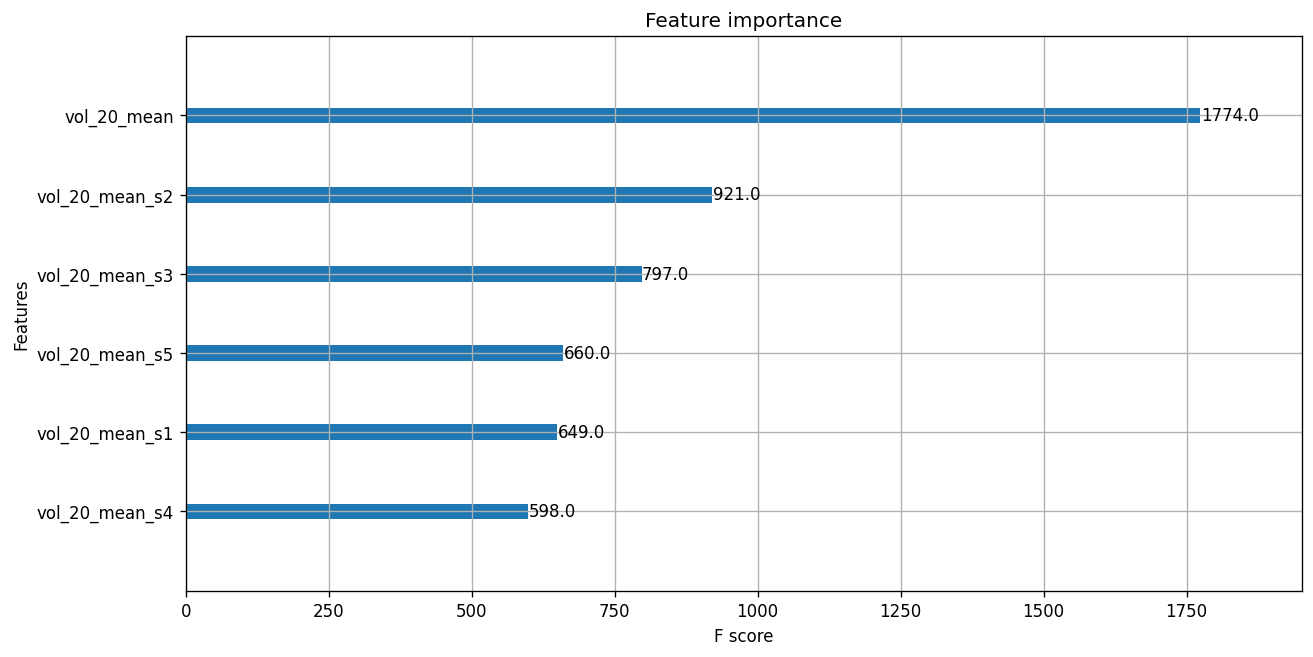

In [92]:
plot_importance(best_model)

In [93]:
y_pred = best_model.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("R2_score:", metrics.r2_score(y_test, y_pred))

Accuracy: 0.5298013245033113
R2_score: -0.9751289609432572


In [94]:
from sklearn.ensemble import GradientBoostingClassifier
# Create GradientBoostingClassifier model
gbc = GradientBoostingClassifier(learning_rate=0.05, random_state=42, n_estimators=200)

# Train
gbc = gbc.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = gbc.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("R2_score:", metrics.r2_score(y_test, y_pred))

Accuracy: 0.6490066225165563
R2_score: -0.4743920412675018


In [95]:
X_result = X_test.copy()
X_result = X_result.assign(Predicts=y_pred)
X_result = X_result[['Predicts']]
data_result = ai_data.copy()
data_result = pd.merge(data_result, X_result, left_index=True, right_index=True, how="left")
data_result.dropna(subset=['Predicts'], inplace=True)
data_result

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,vol_20_mean_s1,vol_20_mean_s2,vol_20_mean_s3,vol_20_mean_s4,vol_20_mean_s5,MACDh,group,Close_group,RSI_14_group,Predicts
1313,1,41626,41673,1204.76132,1202.6,-2.16132,-0.001794,2024-02-06 09:10:00,2024-02-06 14:30:00,None,...,5538.40,5162.80,4959.45,4478.50,3842.25,0.017340,0,"(1197.293, 1222.1]","(68.728, 70.507]",0.0
1314,1,41688,41723,1207.56216,1217.1,9.53784,0.007898,2024-02-07 10:05:00,2024-02-07 14:30:00,None,...,2617.95,2674.15,2743.25,2772.75,2775.05,0.063631,1,"(1197.293, 1222.1]","(65.269, 66.854]",0.0
1315,1,41750,41772,1223.16684,1219.2,-3.96684,-0.003243,2024-02-15 11:05:00,2024-02-15 14:20:00,None,...,1164.45,1234.20,1445.45,1719.15,2214.45,-0.327861,0,"(1222.1, 1236.917]","(65.269, 66.854]",1.0
1316,1,41821,41822,1228.36840,1224.5,-3.86840,-0.003149,2024-02-16 14:10:00,2024-02-16 14:15:00,None,...,2872.20,2696.85,2535.90,2368.65,2113.95,0.232384,0,"(1222.1, 1236.917]","(57.632, 58.96]",0.0
1318,1,41870,41876,1238.97158,1243.8,4.82842,0.003897,2024-02-19 14:00:00,2024-02-19 14:30:00,None,...,2572.00,2253.50,1963.10,1865.15,1860.30,0.422587,1,"(1236.917, 1250.467]","(72.114, 74.964]",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613,1,53650,53768,1309.49273,1324.8,15.30727,0.011689,2025-01-17 09:20:00,2025-01-21 10:40:00,None,...,3595.60,3352.40,2866.40,3100.45,2448.35,1.710397,1,"(1303.317, 1313.667]","(65.269, 66.854]",1.0
1615,1,53854,53899,1324.69729,1342.9,18.20271,0.013741,2025-01-23 09:20:00,2025-01-23 14:30:00,None,...,3983.55,4234.25,3796.00,3800.55,3423.00,0.215034,1,"(1313.667, 1327.01]","(55.68, 57.632]",0.0
1616,1,53922,53950,1340.60206,1342.1,1.49794,0.001117,2025-01-24 10:45:00,2025-01-24 14:30:00,None,...,2868.25,3078.90,3880.95,4390.10,4766.30,-0.242784,1,"(1327.01, 1348.4]","(49.495, 51.822]",1.0
1621,1,54043,54157,1328.39840,1336.6,8.20160,0.006174,2025-02-04 13:45:00,2025-02-07 09:05:00,None,...,3478.00,3390.75,3359.50,3033.45,3122.65,0.045924,1,"(1327.01, 1348.4]","(58.96, 60.462]",0.0


In [96]:
data_result[data_result.group != data_result.Predicts]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,vol_20_mean_s1,vol_20_mean_s2,vol_20_mean_s3,vol_20_mean_s4,vol_20_mean_s5,MACDh,group,Close_group,RSI_14_group,Predicts
1314,1,41688,41723,1207.56216,1217.1,9.53784,0.007898,2024-02-07 10:05:00,2024-02-07 14:30:00,None,...,2617.95,2674.15,2743.25,2772.75,2775.05,0.063631,1,"(1197.293, 1222.1]","(65.269, 66.854]",0.0
1315,1,41750,41772,1223.16684,1219.2,-3.96684,-0.003243,2024-02-15 11:05:00,2024-02-15 14:20:00,None,...,1164.45,1234.20,1445.45,1719.15,2214.45,-0.327861,0,"(1222.1, 1236.917]","(65.269, 66.854]",1.0
1319,1,41893,41927,1240.37200,1241.1,0.72800,0.000587,2024-02-20 10:15:00,2024-02-20 14:30:00,None,...,3321.90,3823.40,3955.30,3896.20,3962.30,-0.327917,1,"(1236.917, 1250.467]","(54.148, 55.68]",0.0
1325,1,42135,42224,1232.66969,1253.0,20.33031,0.016493,2024-02-27 09:10:00,2024-02-28 13:45:00,None,...,4135.80,3818.80,3746.10,3320.45,2971.60,0.361395,1,"(1222.1, 1236.917]","(66.854, 68.728]",0.0
1330,1,42332,42335,1263.37890,1267.4,4.02110,0.003183,2024-03-01 14:15:00,2024-03-01 14:30:00,None,...,3354.10,3014.45,2822.55,2766.20,2483.85,-0.252378,1,"(1250.467, 1265.65]","(49.495, 51.822]",0.0
1337,1,42533,42539,1273.08181,1273.2,0.11819,0.000093,2024-03-07 14:00:00,2024-03-07 14:30:00,None,...,4049.55,3584.05,3698.55,3500.85,3243.15,0.376005,1,"(1272.5, 1282.283]","(60.462, 61.868]",0.0
1341,1,42710,42754,1248.37440,1267.2,18.82560,0.015080,2024-03-13 10:20:00,2024-03-14 09:45:00,None,...,4313.80,4830.60,5480.30,5687.65,5647.80,0.321738,1,"(1236.917, 1250.467]","(70.507, 72.114]",0.0
1347,1,42911,42947,1229.26867,1230.1,0.83133,0.000676,2024-03-19 10:05:00,2024-03-19 14:30:00,None,...,6564.90,6843.80,6737.60,7178.05,6936.20,-0.389743,1,"(1222.1, 1236.917]","(43.244, 46.174]",0.0
1355,1,43196,43202,1286.48583,1287.5,1.01417,0.000788,2024-03-26 14:00:00,2024-03-26 14:30:00,None,...,3742.35,3714.70,3510.05,3290.30,3335.10,0.570338,1,"(1282.283, 1291.4]","(70.507, 72.114]",0.0
1363,1,43523,43531,1278.98358,1275.1,-3.88358,-0.003036,2024-04-04 10:05:00,2024-04-04 10:45:00,None,...,5749.70,6026.60,6506.45,6459.00,6435.30,0.409225,0,"(1272.5, 1282.283]","(51.822, 54.148]",1.0
